In [1]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time, math, random
import gym

### CartPole Problem

Cartpole - known also as an Inverted Pendulum is a pendulum with a center of gravity above its pivot point. It’s unstable, but can be controlled by moving the pivot point under the center of mass. The goal is to keep the cartpole balanced by applying appropriate forces to a pivot point.

##### source: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

**Observation:**

    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

**Actions:**

    Type: Discrete(2)
    Num   Action
    0     Push cart to the left
    1     Push cart to the right
   
**Reward:**

    Reward is 1 for every step taken, including the termination step

**Starting State:**

    All observations are assigned a uniform random value in [-0.05..0.05]

**Episode Termination:**

    Pole Angle is more than 12 degrees.
    Cart Position is more than 2.4 (center of the cart reaches the edge of
    the display).
    Episode length is greater than 200.
    Solved Requirements:
    Considered solved when the average return is greater than or equal to
    195.0 over 100 consecutive trials.

In [2]:
# Show info
# ?env.env

### 2 - Q-Learning

In [3]:
### https://github.com/RJBrooker/Q-learning-demo-Cartpole-V1/blob/master/cartpole.ipynb

class Agent:

    def __init__(self, env, learning_rate=0.01, discount_factor=0.9):
        self.env = env
        
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        
        self.n_bins = ( 6 , 12 )
        self.lower_bounds = [ self.env.observation_space.low[2], -math.radians(50) ]
        self.upper_bounds = [ self.env.observation_space.high[2], math.radians(50) ]
        
        self.q_table = np.zeros(self.n_bins + (self.env.action_space.n,))

    def discretizer(self, _ , __ , angle, pole_velocity ):
        """Convert continues state intro a discrete state"""
        est = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy='uniform')
        est.fit([self.lower_bounds, self.upper_bounds ])
        return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))
    
    def policy(self, state, epsilon):
        if np.random.rand() > epsilon:
            # Exploit
            action = np.argmax(self.q_table[state])
        else:
            # Explore
            action = np.random.randint(len(self.q_table[state]))
        return action

    def load_q_table(self, table_filename):
        table = np.load(table_filename)
        self.q_table = table
    
    def exploration_rate(self, n, min_rate= 0.1 ):
        """Decaying exploration rate"""
        return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

    #def exploration_rate(self, episode, num_episodes):
    #    """# Define exploration rate change over time"""
    #    start_eps = 1.0
    #    end_eps = 0.1
    #    const_eps_episodes = 0.1 * num_episodes  # 10% of learning time
    #    eps_decay_episodes = 0.6 * num_episodes  # 60% of learning time

    #    if episode < const_eps_episodes:
    #        return start_eps
    #    elif episode < eps_decay_episodes:
            # Linear decay
    #        return start_eps - (episode - const_eps_episodes) / \
    #                           (eps_decay_episodes - const_eps_episodes) * (start_eps - end_eps)
    #    else:
    #        return end_eps

    # train the agent for a given number of episodes
    # the agent trains using Q-Learning
    def train(self, training_episodes):
        steps_per_episode = np.zeros((training_episodes))
        run = 0
        for i in range(0, training_episodes):            
            state = self.discretizer(*self.env.reset())
            done = False
            num_steps = 0
            run+=1
            
            while not done:       
                num_steps += 1
                
                #epsilon = self.exploration_rate(i, training_episodes)
                epsilon = self.exploration_rate(i)
                
                action = self.policy(state, epsilon)
         
                next_state, reward, done, _ = self.env.step(action)
            
                if reward < 0.:
                    print("reward ", reward)
                    
                next_state = self.discretizer(*next_state)
                
                q_value = self.q_table[state][action]
            
                max_q = np.max(self.q_table[next_state])

                new_q = q_value + self.learning_rate * (reward + self.discount_factor * max_q - q_value)
                self.q_table[state][action] = new_q

                state = next_state
                
                #if done:
                #    print("Run: " + str(run), "score: "  + str(num_steps))
            
            # total num of steps per episode
            steps_per_episode[i] = num_steps
        
        print("\nAvg num of steps per episode: " + str(np.mean(steps_per_episode)))
        plt.plot(steps_per_episode)
        plt.show()  

        outfile = open('q_table', 'wb')
        np.save(outfile, self.q_table)
        outfile.close()

    # test the agent for a given number of episodes
    # if render is active, it will print the steps and total reward
    def test(self, testing_episodes, render=False):
    
        MAX_ITERS = 100
        frames = []
        total_penalties = 0
        steps_per_episode = np.zeros((testing_episodes))
        
        for i in range(testing_episodes):
            
            state = self.discretizer(*self.env.reset())
            done = False
            total_reward = 0
            steps = []
            penalties, reward = 0, 0

            num_iters = 0
            
            while not done and num_iters < MAX_ITERS:
                action = np.argmax(self.q_table[state])
                steps.append(action)
                
                state, reward, done, _ = self.env.step(action)
                state = self.discretizer(*state)
                total_reward += reward

                num_iters += 1
        
                # Put each rendered frame into dict for animation
                if render:
                    clear_output(wait=True)
                    self.env.render()
                
                # total num of steps per episode
                steps_per_episode[i] = num_iters
                
        print(f"Results after {testing_episodes} episodes:")
        print(f"Average timesteps per episode: {np.mean(steps_per_episode)}")


Avg num of steps per episode: 21.8581


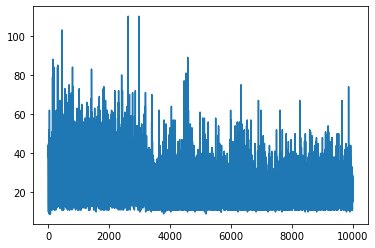

In [4]:
env = gym.make("CartPole-v1")
agent = Agent(env)
training_episodes = 10000
agent.train(training_episodes)

In [5]:
testing_episodes = 20
agent.test(testing_episodes, render=True)

Results after 20 episodes:
Average timesteps per episode: 20.1
